In [6]:
import csv
import pandas as pd
import requests
import urllib.request
from IPython.display import Image
import spacy
from PIL import Image, ImageDraw, ImageFont
!pip install -U stanza
import stanza
import string
from os import listdir
import matplotlib.pyplot as plt
import os
import re
!pip install -U PySimpleGUI
import PySimpleGUI as sg
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageTk,ImageDraw,ImageFont
import warnings
warnings.filterwarnings("ignore")
#stanza.download('it')
nlp=stanza.Pipeline('it',processors='tokenize,mwt,pos,lemma')
from google.colab import drive
drive.mount("/content/drive")

def try_synset(lemmax):
  global synsetFound
  
  synsetsList=[]
  for synset in wn.synsets(lemmax,lang=('ita')):
      for lemma in synset.lemma_names(u'ita'):
          if(lemmax!=lemma):
            synsetsList.append(lemma)
  for i in range(len(synsetsList)):
    response = requests.get("https://api.arasaac.org/api/pictograms/it/search/" + synsetsList[i])
    status = response.status_code
    if status == 200:
      synsetFound=True
      j = response.json()
      id = j[0]['_id']
      return id

def text_on_img(filename, text, size):
    
    if(len(text)<5):
      fnt = ImageFont.truetype('/content/drive/MyDrive/arial.ttf', size)
    else:
      size=size-20
      fnt = ImageFont.truetype('/content/drive/MyDrive/arial.ttf', size)
    W, H = (280,280)
    # create image
    image = PIL.Image.new(mode = "RGB", size = (W,H), color = "white")
    draw = ImageDraw.Draw(image)
    w, h = draw.textsize(text,font=fnt)
    # draw text
    draw.text((((W-w)/2,(H-h)/3)), text,font=fnt, fill=(0,0,0))
    # save file
    image.save(path_CAA_pictograms+filename)

def getInfo(word):
    global synsetFound
    synsetFound=False
    global index

    type=word[1]
    if(type!='PROPN'):
      token=word[0].lower()
      lemma=word[2].lower()
    else:
      token = word[0]
      lemma=word[2]
    gender=""
    """if(type=='DET'):
      lemma=token"""
    if(type=='NOUN'):
      lemma=token
    if(type=='NOUN' or type=='DET' or type=='PRON' or type=='ADJ'):
      if(word[3]!=None):

        splitted=word[3].split("|")
        for i in range(len(splitted)):
            if splitted[i].find("Gender")!=-1:
              gender=splitted[i].split("=")[1]
        if(gender=="Fem" and gender!=""):
          lemma=token
    #lemma=word[2]
    action = 'indef'
    result = []

    #identify if the word is a verb or auxiliar    
    if (type == 'AUX'):
        
        tense=word[3].split("|")[3].split("=")[1]
        
        if(tense=="Past" or tense=="Imp"):
          action="past"
        if(tense=="Fut"):
          action='future'
    
    if (type == 'VERB'):
        if not word[3].split("=")[1]=="Inf":
              
            tense=word[3].split("|")[2].split("=")[1]
            
            if(tense=="Past" or tense=="Imp"):
              action="past"
            if(tense=="Fut"):
              action='future'
    
    result.append(lemma) #add to the list the token  #TOKENCAA [0]
    result.append(action) #add to the list the action   #ACTION [1]

    number="sing"
    if(type!='ADP' and type!='ADV' and type!='INTJ' and type!='PUNCT' and type!='CCONJ' and type!='PROPN' and type!='SCONJ' and type!='X'):
      if(word[3]!=None):
          
        plural=word[3].split("|")
        
        for i in range(len(plural)):
            if plural[i].find("Number")!=-1:
              number=plural[i].split("=")[1]
              
    result.append(number)
    response = requests.get("https://api.arasaac.org/api/pictograms/it/search/" + lemma) #Obtain best pictograms based on the searchText
    status = response.status_code
    if status == 200:

      j = response.json()
      keywords=[]
      for word2 in j:
          try:
            keyword=word2["keywords"][0]["keyword"]
            if(len(keyword)>=len(token)):
              if(len(keyword)>3):
                keywords.append(keyword)
            if(len(keywords)==10):
              break
          except:
            print("Something went wrong")
      if(len(keywords)>0):
        """if(keywords[0]!=token):
          keywords=[]"""
        keywords=[s for s in keywords if s != lemma and s != word[2] ]
        present=False
        for keyword in keywords:
            
            if lemma_sentence.find(keyword)!=-1:
                present=True
                words=len(keyword.split(" "))
                print(words,": ",keyword)
                global index
                index+=words
                global words_for_images
                words_for_images.append(keyword)
                response2 = requests.get("https://api.arasaac.org/api/pictograms/it/bestsearch/" + keyword)
                j2=response2.json()
                id = j2[0]['_id']
                result.append(id)
                index+=1
                return result
                break
    
    response = requests.get("https://api.arasaac.org/api/pictograms/it/bestsearch/" + lemma)
    j = response.json()
    status = response.status_code
    if status == 200:
      
      id = j[0]['_id'] #extract id by response
      result.append(id) #add to the list the id #ID [2]
      
      words_for_images.append(token)
      
      return result
    elif status == 404:
      print('404-no pictogram associated with this word exists =', lemma)
      id=try_synset(lemma)
      if(synsetFound==True):
        result.append(id)
        words_for_images.append(token)
        return result
      else:
        print("No synset found")
        #print('saving img n: ',index)
        if(type=='VERB' or type=='AUX'):
          text_on_img(filename=str(index)+".png",text=token, size=70)
          words_for_images.append(token)
          index_list.append(index)
        else:
          text_on_img(filename=str(index)+".png",text=lemma, size=70)
          words_for_images.append(lemma)
          index_list.append(index)
        index+=1
        
        return result
    elif status == 400:
      print('400-no pictogram associated with this word exists =', lemma)
      #print('saving img n: ',index)
      if(type=='VERB' or type=='AUX'):
        text_on_img(filename=str(index)+".png",text=token, size=100)
        words_for_images.append(token)
        index_list.append(index)
      else:
        text_on_img(filename=str(index)+".png",text=lemma, size=100)
        words_for_images.append(lemma)
        index_list.append(index)
      index+=1
      
      return result
    elif status == 500:
      print('500 status')
      index+=1
      words_for_images.append(lemma)
      
      return result
    
path_CAA_pictograms = "/content/drive/MyDrive/immagini/"

def getArray_id(words):
  array_id = []
  infos=[]
  global pics
  pics=[]
  global index
  while index<len(words):
    info = getInfo(words[index]) #TOKENCAA [0] | ACTION [1] | PLURAL_STATUS[2] | ID[3]
    #print("info:",info)
    if(len(info)==4):
      pics.append(info[3])
    infos.append(info)
    if(len(info)==4):

      action = info[1]
      id = info[3]
      plural_status = info[2]
      array_id.append(id) #add id to array_id
      getImg(id, plural_status,action) #save img
  
  return infos

def getImg(id, plural_status,action): #parameter:id, plural_status, action
  #print('id','id')
  global index
  global index_list
  if plural_status=="Plur":
    #Copy a network object denoted by a URL to a local file
    urllib.request.urlretrieve('https://static.arasaac.org/pictograms/'+str(id)+'/'+str(id)+'_plural_300.png',
   path_CAA_pictograms+str(index)+'.png')
    #print('saving img n: ',index)
    index_list.append(index)
    index+=1
    
  elif not action == 'indef':
    #Copy a network object denoted by a URL to a local file
    urllib.request.urlretrieve('https://static.arasaac.org/pictograms/'+str(id)+'/'+str(id)+'_action-'+action+'_300.png',
   path_CAA_pictograms +str(index)+'.png')
    #print('saving img n: ',index)
    index_list.append(index)
    index+=1
    
  else:
     #Copy a network object denoted by a URL to a local file
    urllib.request.urlretrieve('https://static.arasaac.org/pictograms/'+str(id)+'/'+str(id)+'_300.png',
   path_CAA_pictograms+str(index)+'.png')
    #print('saving img n: ',index)
    index_list.append(index)
    index+=1

def translate(input_text):
  global index
  index=0
  global index_list
  index_list=[]
  global lemma_sentence
  lemma_sentence=""
  global words_for_images
  words_for_images=[]
  frase=str(input_text)
  #print(frase)
  frase=re.sub(r"[-()\"#/@;:<>{}`+=~|$%&]", "", frase)
  #frase= input()
  #words_for_images=[]

  import glob
  fileList = glob.glob('/content/drive/MyDrive/ImagesSingleTranslation/*.png')
  for filePath in fileList:
    os.remove(filePath)

  doc=nlp(frase)
  #index=0
  lemmas=[]
  for sentence in doc.sentences:
      posT=[(w.text, w.pos,w.lemma,w.feats) for w in sentence.words]
      print(posT)
      for i in posT:
        lemmas.append(i[2])
      lemma_sentence=""
      for i in lemmas:
        lemma_sentence+=i
        lemma_sentence+=" "
      getArray_id(posT)

      print('words for images: ',words_for_images)
      print('pics: ',pics)
                      
      #plt.show()
      return(pics)

index=0
lemma_sentence=""
words_for_images=[]
pics=[]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: it (Italian):
| Processor | Package  |
------------------------
| tokenize  | combined |
| mwt       | combined |
| pos       | combined |
| lemma     | combined |

INFO:stanza:Use device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Done loading processors!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[('Gioco', 'NOUN', 'gioco', 'Gender=Masc|Number=Sing'), ('in', 'ADP', 'in', None), ('un', 'DET', 'uno', 'Definite=Ind|Gender=Masc|Number=Sing|PronType=Art'), ('campo', 'NOUN', 'campo', 'Gender=Masc|Number=Sing'), ('da', 'ADP', 'da', None), ('tennis', 'NOUN', 'tennis', 'Gender=Masc|Number=Sing')]
3 :  campo da tennis
words for images:  ['gioco', 'in', 'un', 'campo da tennis']
pics:  [9810, 7034, 2627, 5068]


,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

gioco


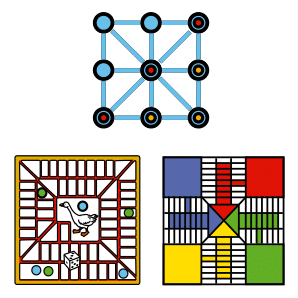

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

in


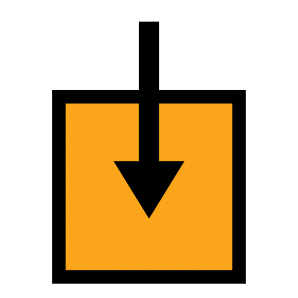

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

un


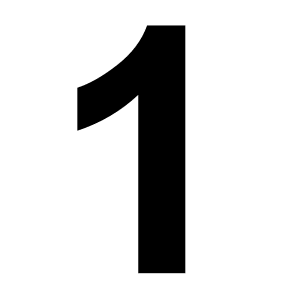

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

campo da tennis


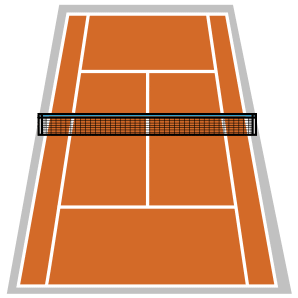

<IPython.core.display.Javascript object>

In [7]:
from google.colab import widgets
from IPython.display import Image, display
translate("Gioco in un campo da tennis")
grid=widgets.Grid(1,len(words_for_images),header_row=True,header_column=True)
j=0
for word, i in zip(words_for_images, index_list):
  with grid.output_to(0, j):
      print(word)
      display(Image(path_CAA_pictograms+str(i)+'.png',width=70, height=70))
      j+=1